# Which tree species should the city plant?

## 📖 Background
You work for a nonprofit organization advising the planning department on ways to improve the quantity and quality of trees in New York City. The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

The city would like to learn more about which tree species are the best choice to plant on the streets of Manhattan.

## 💾 The data
The team has provided access to the 2015 tree census and geographical information on New York City neighborhoods ([trees](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz)):

#### Tree Census
- "tree_id" - Unique id of each tree.
- "tree_dbh" - The diameter of the tree in inches measured at 54 inches above the ground.
- "curb_loc" - Location of the tree bed in relation to the curb. Either along the curb (OnCurb) or offset from the curb (OffsetFromCurb).
- "spc_common" - Common name for the species.
- "status" - Indicates whether the tree is alive or standing dead.
- "health" - Indication of the tree's health (Good, Fair, and Poor).
- "root_stone" - Indicates the presence of a root problem caused by paving stones in the tree bed.
- "root_grate" - Indicates the presence of a root problem caused by metal grates in the tree bed.
- "root_other" - Indicates the presence of other root problems.
- "trunk_wire" - Indicates the presence of a trunk problem caused by wires or rope wrapped around the trunk.
- "trnk_light" - Indicates the presence of a trunk problem caused by lighting installed on the tree.
- "trnk_other" - Indicates the presence of other trunk problems.
- "brch_light" - Indicates the presence of a branch problem caused by lights or wires in the branches.
- "brch_shoe" - Indicates the presence of a branch problem caused by shoes in the branches.
- "brch_other" - Indicates the presence of other branch problems.
- "postcode" - Five-digit zip code where the tree is located.
- "nta" - Neighborhood Tabulation Area (NTA) code from the 2010 US Census for the tree.
- "nta_name" - Neighborhood name.
- "latitude" - Latitude of the tree, in decimal degrees.
- "longitude" - Longitude of the tree, in decimal degrees.

#### Neighborhoods' geographical information
- "ntacode" - NTA code (matches Tree Census information).
- "ntaname" - Neighborhood name (matches Tree Census information).
- "geometry" - Polygon that defines the neighborhood.

_Tree census and neighborhood information from the City of New York [NYC Open Data](https://opendata.cityofnewyork.us/data/)._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno
import contextily as cx

In [2]:
trees = pd.read_csv('data/trees.csv')
trees

tree_id  tree_dbh  ...   latitude  longitude
0       190422        11  ...  40.770046 -73.984950
1       190426        11  ...  40.770210 -73.985338
2       208649         9  ...  40.762724 -73.987297
3       193310        14  ...  40.772171 -73.960456
4       199760         4  ...  40.782087 -73.980964
...        ...       ...  ...        ...        ...
64224   208765        11  ...  40.763224 -73.960984
64225   170513         9  ...  40.707884 -74.017598
64226   190040        10  ...  40.786150 -73.971152
64227   191269        12  ...  40.739270 -73.983960
64228   192812         5  ...  40.739913 -74.004892

[64229 rows x 20 columns]

In [3]:
neighborhoods = gpd.read_file('data/nta.shp')
neighborhoods

borocode  ...                                           geometry
0         3.0  ...  POLYGON ((-73.94733 40.62917, -73.94687 40.626...
1         3.0  ...  POLYGON ((-73.94193 40.70073, -73.94439 40.700...
2         2.0  ...  POLYGON ((-73.89138 40.86170, -73.89106 40.861...
3         3.0  ...  POLYGON ((-73.97605 40.63128, -73.97717 40.630...
4         3.0  ...  POLYGON ((-73.90856 40.65210, -73.90945 40.651...
..        ...  ...                                                ...
190       2.0  ...  POLYGON ((-73.91192 40.84326, -73.91194 40.843...
191       4.0  ...  POLYGON ((-73.83103 40.71434, -73.83115 40.714...
192       4.0  ...  MULTIPOLYGON (((-73.86523 40.57046, -73.86454 ...
193       4.0  ...  POLYGON ((-73.75763 40.66645, -73.75756 40.666...
194       4.0  ...  MULTIPOLYGON (((-73.74712 40.63716, -73.74707 ...

[195 rows x 8 columns]

In [4]:
# let's see if there is missing data in the datasets

trees.isnull().sum()

tree_id          0
tree_dbh         0
curb_loc         0
spc_common    1801
status           0
health        1802
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trnk_light       0
trnk_other       0
brch_light       0
brch_shoe        0
brch_other       0
postcode         0
nta              0
nta_name         0
latitude         0
longitude        0
dtype: int64

In [5]:
neighborhoods.isnull().sum()

borocode      0
boroname      0
countyfips    0
ntacode       0
ntaname       0
shape_area    0
shape_leng    0
geometry      0
dtype: int64

<AxesSubplot: >

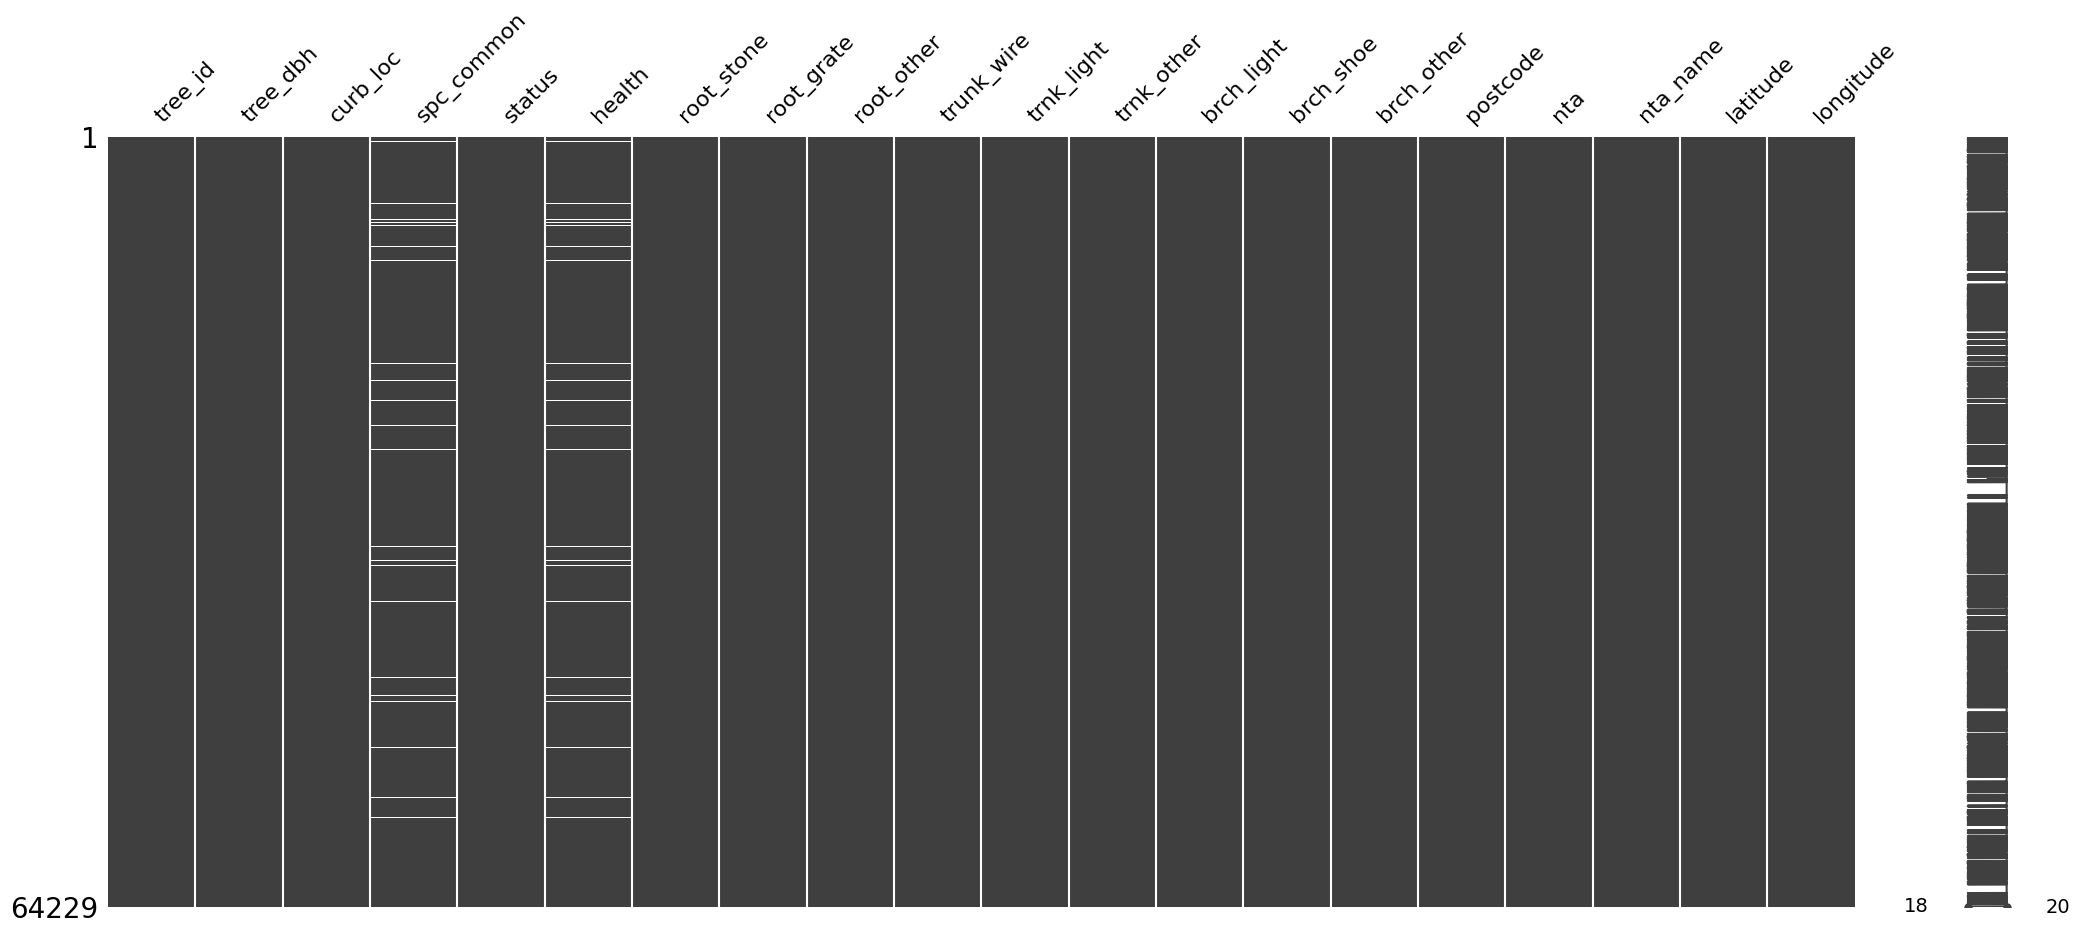

In [6]:
# there is missing data in the trees dataset
# let's visualize that

msno.matrix(trees)

<AxesSubplot: >

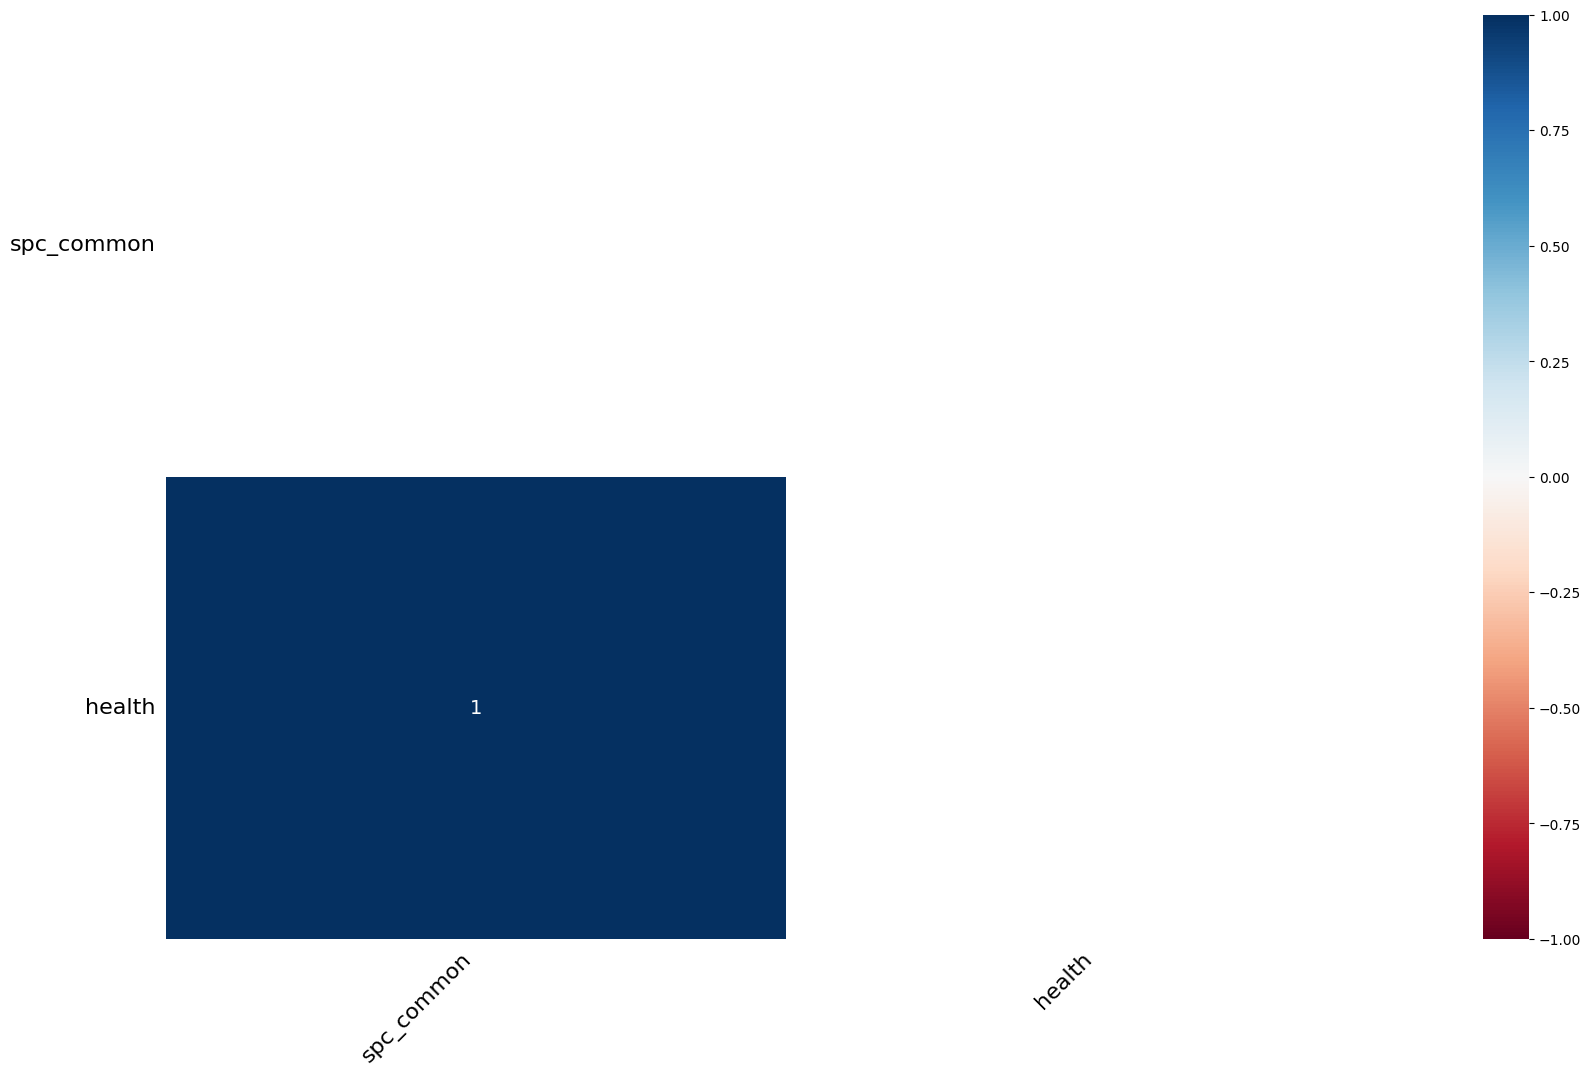

In [7]:
# apparently, both columns spc_common and health have the same rows with missing data. we can confirm that using the heatmap

msno.heatmap(trees)

The correlation is equal to 1, so all the missing data in the column "spc_common" is the same in the column "health". 

In [8]:
# let's try to understand that

trees_md = trees[trees["health"].isnull()]
trees_md

tree_id  tree_dbh  ...   latitude  longitude
79      188609         9  ...  40.771992 -73.951657
106     189412         7  ...  40.807979 -73.959649
169     173517         8  ...  40.735202 -74.005829
173     200440         3  ...  40.712705 -73.997585
225     195980         3  ...  40.745469 -73.985202
...        ...       ...  ...        ...        ...
63941   175093         3  ...  40.715980 -73.996222
63980   194257         2  ...  40.720428 -73.982375
63981   192618         2  ...  40.717588 -73.991245
63983   196070         0  ...  40.762000 -73.989176
64210   156162         3  ...  40.785136 -73.951109

[1802 rows x 20 columns]

After all, the missing data is just dead trees...

In [9]:
# since they aren't relevant here, we can get rid of them

live_trees = trees.dropna(axis=0)
live_trees["spc_common"] = live_trees["spc_common"].str.capitalize()
live_trees

tree_id  tree_dbh  ...   latitude  longitude
0       190422        11  ...  40.770046 -73.984950
1       190426        11  ...  40.770210 -73.985338
2       208649         9  ...  40.762724 -73.987297
3       193310        14  ...  40.772171 -73.960456
4       199760         4  ...  40.782087 -73.980964
...        ...       ...  ...        ...        ...
64224   208765        11  ...  40.763224 -73.960984
64225   170513         9  ...  40.707884 -74.017598
64226   190040        10  ...  40.786150 -73.971152
64227   191269        12  ...  40.739270 -73.983960
64228   192812         5  ...  40.739913 -74.004892

[62427 rows x 20 columns]

# What are the most common tree species in Manhattan?

In [10]:
most_common_trees = live_trees["spc_common"].value_counts().reset_index()
most_common_trees.rename(columns={"index":"name", "spc_common":"count"}, inplace=True)
most_common_trees.head(10)

name  count
0        Honeylocust  13175
1       Callery pear   7297
2             Ginkgo   5859
3            Pin oak   4584
4            Sophora   4453
5   London planetree   4122
6   Japanese zelkova   3596
7  Littleleaf linden   3333
8       American elm   1698
9    American linden   1583

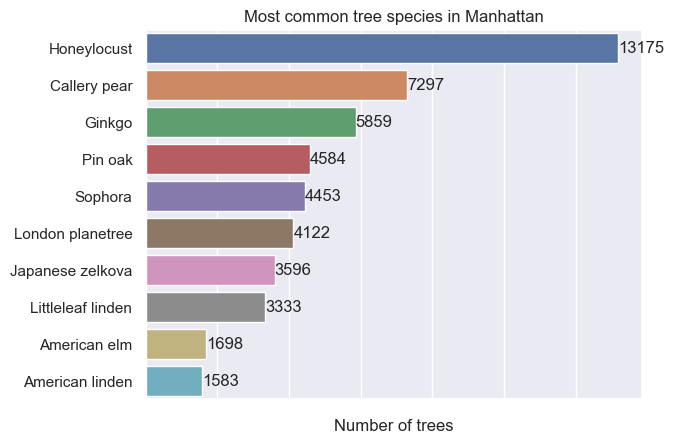

In [11]:
# let's visualize it with a bar plot

sns.set_theme(palette='deep')
ax = sns.barplot(data=most_common_trees[:10], x="count", y="name")
ax.set(title="Most common tree species in Manhattan", xlabel="Number of trees", ylabel="")
ax.set(xticklabels=[]) 
ax.bar_label(ax.containers[0])
plt.show()

# Which are the neighborhoods with the most trees?

In [12]:
neighborhoods_most_trees = live_trees["nta_name"].value_counts().reset_index()
neighborhoods_most_trees.rename(columns={"index":"neighborhood","nta_name":"number_of_trees"}, inplace=True)
print(neighborhoods_most_trees.head(10))
avg_trees = int(neighborhoods_most_trees.mean())
print(f"The average number of trees in Manhattan's neighborhoods is: {avg_trees}")

                                 neighborhood  number_of_trees
0                             Upper West Side             5723
1               Upper East Side-Carnegie Hill             4540
2                                West Village             3715
3           Central Harlem North-Polo Grounds             3355
4  Hudson Yards-Chelsea-Flatiron-Union Square             2797
5                    Washington Heights South             2788
6                         Morningside Heights             2642
7                        Central Harlem South             2581
8                    Washington Heights North             2519
9                           East Harlem North             2398
The average number of trees in Manhattan's neighborhoods is: 2229


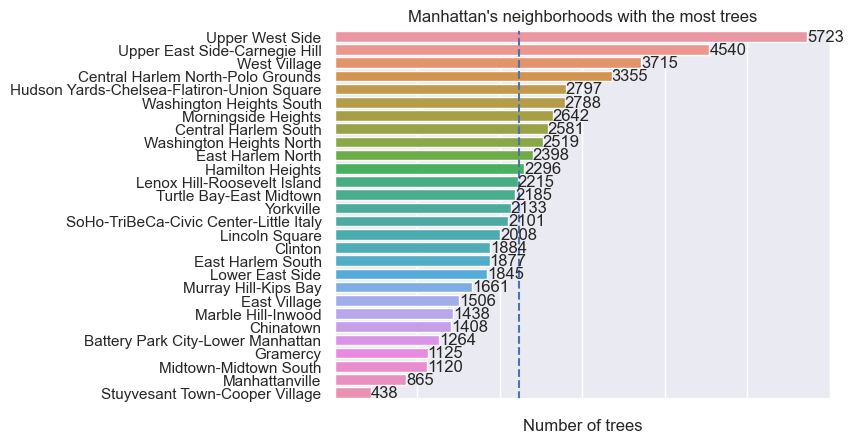

In [13]:
# let's visualize it with a bar plot

ax = sns.barplot(data=neighborhoods_most_trees, x="number_of_trees", y="neighborhood")
ax.set(title="Manhattan's neighborhoods with the most trees", xlabel="Number of trees", ylabel="")
ax.set(xticklabels=[]) 
ax.bar_label(ax.containers[0])
plt.axvline(x=avg_trees, color = 'b', linestyle="--")
plt.show()

Apparently, Upper West Side is the neighborhood with the most trees. Is that necessarily true?

In [14]:
# to answer that, we need to verify the number of shape area per tree --> we need to merge both datasets

# 1 - keep only Manhattan's neighborhoods
manhattan = neighborhoods[neighborhoods["boroname"] == "Manhattan"]

# 2 - get summary data from live_trees
group_nta = live_trees["nta"].value_counts().reset_index()
group_nta.rename(columns={"index":"ntacode", "nta":"number_trees"}, inplace=True)

# 3 - merge datasets
merged_data = manhattan.merge(group_nta, how="left", on="ntacode")

# 4 - verify if there's missing data
print(merged_data.isnull().sum())

borocode        0
boroname        0
countyfips      0
ntacode         0
ntaname         0
shape_area      0
shape_leng      0
geometry        0
number_trees    1
dtype: int64


In [15]:
# 4 - delete the missing data
merged_data.dropna(axis=0, inplace=True)
merged_data

borocode  ... number_trees
0        1.0  ...       1506.0
1        1.0  ...       2133.0
2        1.0  ...       4540.0
3        1.0  ...       2642.0
4        1.0  ...        865.0
5        1.0  ...       3715.0
6        1.0  ...       1408.0
7        1.0  ...        438.0
8        1.0  ...       1845.0
9        1.0  ...       1438.0
10       1.0  ...       2519.0
11       1.0  ...       3355.0
12       1.0  ...       2101.0
13       1.0  ...       1264.0
14       1.0  ...       1884.0
15       1.0  ...       1877.0
16       1.0  ...       2398.0
17       1.0  ...       2581.0
18       1.0  ...       1120.0
19       1.0  ...       1661.0
20       1.0  ...       2185.0
21       1.0  ...       2215.0
22       1.0  ...       2296.0
23       1.0  ...       5723.0
24       1.0  ...       2008.0
26       1.0  ...       2797.0
27       1.0  ...       1125.0
28       1.0  ...       2788.0

[28 rows x 9 columns]

In [16]:
# let's calculate the number of shape area per tree
merged_data["area_per_tree"] = round(merged_data["shape_area"] / merged_data["number_trees"])
merged_data.sort_values("area_per_tree", ascending=True, inplace=True)
merged_data.head()

borocode   boroname  ... number_trees area_per_tree
2        1.0  Manhattan  ...       4540.0        4420.0
17       1.0  Manhattan  ...       2581.0        5593.0
23       1.0  Manhattan  ...       5723.0        6008.0
1        1.0  Manhattan  ...       2133.0        6374.0
27       1.0  Manhattan  ...       1125.0        6695.0

[5 rows x 10 columns]

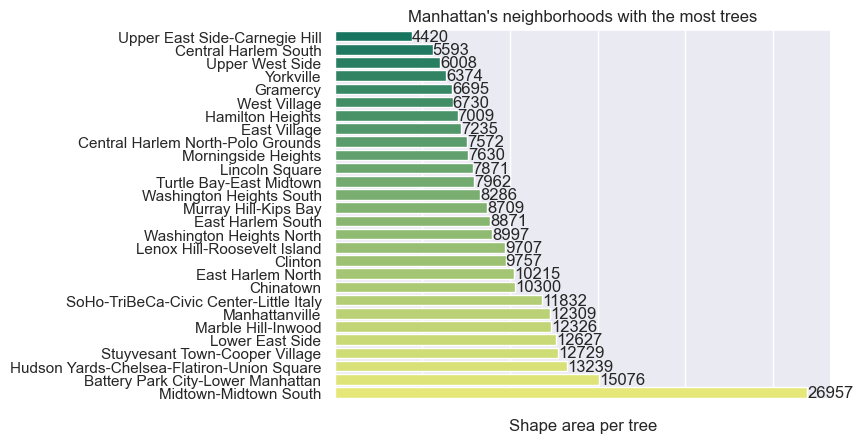

In [17]:
# now let's create a bar plot 
ax = sns.barplot(data=merged_data, x="area_per_tree", y="ntaname", palette="summer")
ax.set(title="Manhattan's neighborhoods with the most trees", xlabel="Shape area per tree", ylabel="")
ax.set(xticklabels=[]) 
ax.bar_label(ax.containers[0])
plt.show()

If we look at this plot, we can see a slight difference from the last one. Here, we can see which neighborhoods have the most trees related to their shape area, i.e., which neighborhoods are greener:
1. Upper East Side-Carnegie Hill
2. Central Harlem South
3. Upper West Side

Thus, if you look for a place with lots of green in Manhattan, you should go to those neighborhoods.

# A visualization of Manhattan's neighborhoods and tree locations.

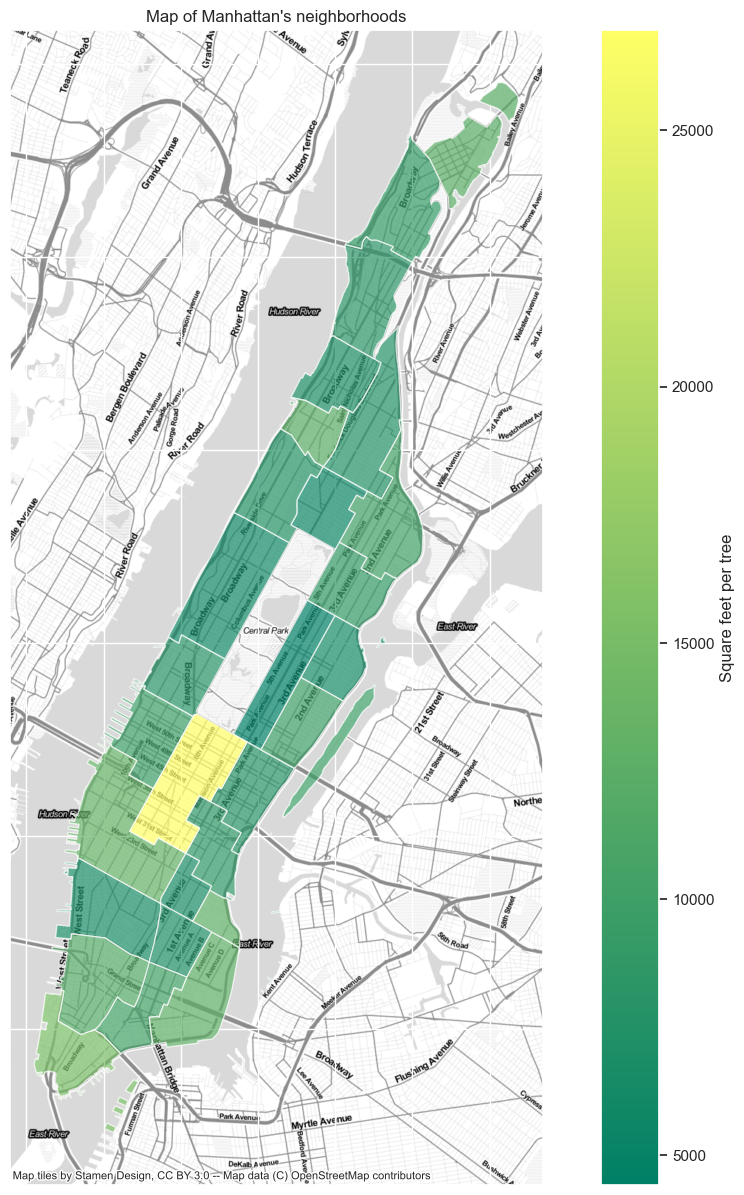

In [18]:
geo_df = merged_data.to_crs(epsg=3857)
ax = geo_df.plot(column="area_per_tree", figsize=(15, 15), legend=True, alpha=0.7, cmap="summer", legend_kwds={"label": "Square feet per tree"})
ax.set_title("Map of Manhattan's neighborhoods")
ax.set(xticklabels=[], yticklabels=[]) 

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)    # adds a base map (style)
plt.show()

[]

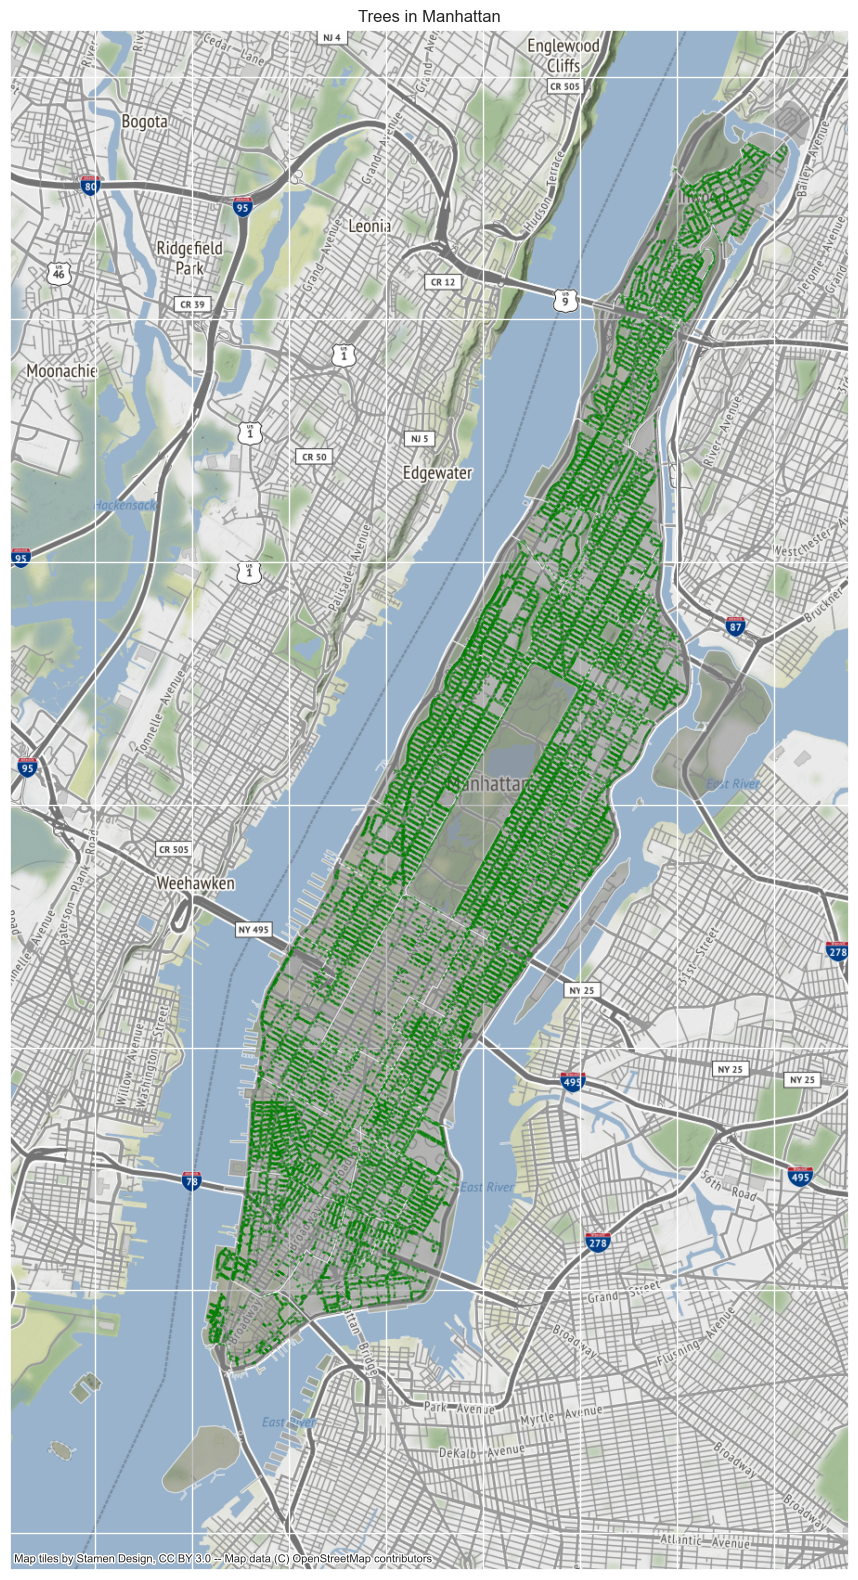

In [19]:
base_map = manhattan.to_crs(epsg=3857)
ax = base_map.plot(figsize=(40,20), alpha=0.5, color="grey")
ax.set(xticklabels=[], yticklabels=[]) 
plt.title("Trees in Manhattan")


crs={"init":"epsg:4326"}
geo_df = gpd.GeoDataFrame(live_trees, crs=crs, geometry=gpd.points_from_xy(live_trees["longitude"], live_trees["latitude"]))
# create a GeoDataFrame with geometry points
geo_df_pt = geo_df.to_crs(epsg=3857)
geo_df_pt.plot(ax=ax, markersize = 0.2, alpha=0.5, color = "green", marker = "o")    # plot the points in the map

cx.add_basemap(ax)
plt.plot()

# What ten tree species would you recommend the city plant in the future?

In [20]:
# first of all, let's see the which species are healthier

heal_spec = live_trees[["spc_common", "health"]]
heal_spec_reshape = pd.get_dummies(heal_spec, columns=["health"])
group = heal_spec_reshape.groupby("spc_common").sum().reset_index()
group = group[["spc_common", "health_Good", "health_Fair", "health_Poor"]]
group["sum"] = group["health_Good"] + group["health_Fair"] + group["health_Poor"]
group

spc_common  health_Good  health_Fair  health_Poor   sum
0    'schubert' chokecherry          111           40           12   163
1            American beech           15            4            3    22
2              American elm         1361          259           78  1698
3      American hophornbeam           64           12            8    84
4         American hornbeam           67           13            5    85
..                      ...          ...          ...          ...   ...
123          Weeping willow            8            4            0    12
124               White ash           40            8            2    50
125               White oak          162           56           23   241
126              White pine            0            1            0     1
127              Willow oak          747          115           27   889

[128 rows x 5 columns]

In [21]:
# since some species don't have a sufficient number of trees, it's better to filter our dataset 
# i think >50 trees is better to our analysis

group_filter = group[group["sum"] >= 50]
good_health = group_filter["health_Good"]
perc_good = round(group_filter["health_Good"] * 100 / group_filter["sum"])
group_filter["percentage"] = perc_good
group_filter

spc_common  health_Good  ...    sum  percentage
0    'schubert' chokecherry          111  ...    163        68.0
2              American elm         1361  ...   1698        80.0
3      American hophornbeam           64  ...     84        76.0
4         American hornbeam           67  ...     85        79.0
6           American linden         1020  ...   1583        64.0
8              Amur maackia           46  ...     59        78.0
11                      Ash           40  ...     58        69.0
13             Bald cypress           56  ...     89        63.0
16             Black locust          201  ...    259        78.0
18                Black oak          144  ...    192        75.0
25             Callery pear         5382  ...   7297        74.0
27                   Cherry          674  ...    869        78.0
29              Chinese elm          604  ...    785        77.0
33         Common hackberry          108  ...    170        64.0
35               Crab apple          371  ...    437        85.0
39             Dawn redwood          121  ...    199        61.0
43           Eastern redbud           38  ...     50        76.0
46              English oak          150  ...    197        76.0
49        European hornbeam          126  ...    167        75.0
50        Flowering dogwood           37  ...     65        57.0
51                   Ginkgo         4386  ...   5859        75.0
52          Golden raintree          318  ...    359        89.0
53                Green ash          575  ...    770        75.0
54        Hardy rubber tree           47  ...     66        71.0
55                 Hawthorn          181  ...    219        83.0
59              Honeylocust        10958  ...  13175        83.0
61        Japanese hornbeam           47  ...     62        76.0
64      Japanese tree lilac           93  ...    129        72.0
65         Japanese zelkova         2773  ...   3596        77.0
67      Kentucky coffeetree          296  ...    348        85.0
70        Littleleaf linden         2076  ...   3333        62.0
71         London planetree         2597  ...   4122        63.0
72                 Magnolia           94  ...    116        81.0
75                 Mulberry           48  ...     68        71.0
76         Northern red oak          820  ...   1143        72.0
77             Norway maple          157  ...    290        54.0
87                  Pin oak         3731  ...   4584        81.0
91         Purple-leaf plum           81  ...    110        74.0
94                Red maple          224  ...    356        63.0
98             Sawtooth oak          301  ...    353        85.0
99              Scarlet oak           56  ...     71        79.0
100          Schumard's oak          111  ...    137        81.0
103             Shingle oak          165  ...    205        80.0
104            Siberian elm          131  ...    156        84.0
106           Silver linden          382  ...    541        71.0
107            Silver maple           37  ...     71        52.0
109                 Sophora         3554  ...   4453        80.0
114         Swamp white oak          549  ...    681        81.0
115                Sweetgum          151  ...    227        67.0
118          Tree of heaven           82  ...    104        79.0
124               White ash           40  ...     50        80.0
125               White oak          162  ...    241        67.0
127              Willow oak          747  ...    889        84.0

[53 rows x 6 columns]

[]

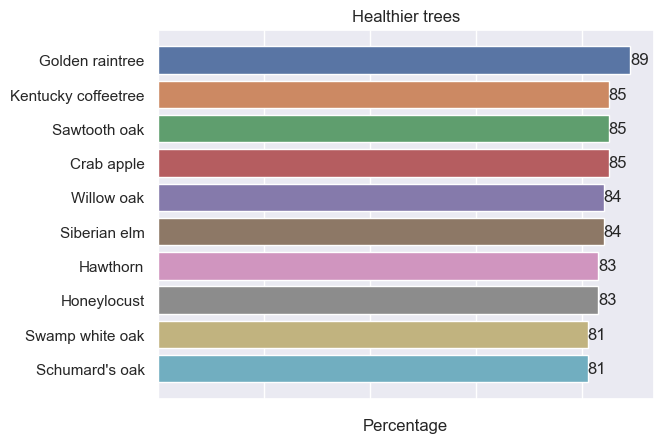

In [22]:
# let's visualize our results

bests = group_filter.sort_values("percentage", ascending=False)
ax = sns.barplot(data=bests[:10], x="percentage", y="spc_common")
ax.set(title="Healthier trees", xlabel="Percentage", ylabel="")
ax.set(xticklabels=[]) 
ax.bar_label(ax.containers[0])
plt.plot()

In [23]:
# now we can look at the diameter

diameter = live_trees[["spc_common", "tree_dbh"]]
mean_per_specie = round(diameter.groupby("spc_common").agg(np.mean), 2).reset_index()
mean_per_specie

spc_common  tree_dbh
0    'schubert' chokecherry      4.90
1            American beech      5.23
2              American elm     13.90
3      American hophornbeam      8.35
4         American hornbeam      5.16
..                      ...       ...
123          Weeping willow     13.50
124               White ash      9.80
125               White oak      5.24
126              White pine     13.00
127              Willow oak     10.81

[128 rows x 2 columns]

In [57]:
# let's merge the information

diam_heal = group_filter.merge(mean_per_specie, how="left", on="spc_common")


# also, it's good to define a bottom value to diameter and percentage

diam_heal = diam_heal[(diam_heal["percentage"] >= 70) & (diam_heal["tree_dbh"] >= 8)]
diam_heal

spc_common  health_Good  health_Fair  ...    sum  percentage  tree_dbh
1           American elm         1361          259  ...   1698        80.0     13.90
2   American hophornbeam           64           12  ...     84        76.0      8.35
8           Black locust          201           52  ...    259        78.0      9.77
10          Callery pear         5382         1474  ...   7297        74.0      8.68
20                Ginkgo         4386          982  ...   5859        75.0      8.45
22             Green ash          575          150  ...    770        75.0      9.26
25           Honeylocust        10958         2012  ...  13175        83.0      9.06
33              Mulberry           48           15  ...     68        71.0     11.00
36               Pin oak         3731          719  ...   4584        81.0     10.07
43          Siberian elm          131           18  ...    156        84.0     12.06
46               Sophora         3554          713  ...   4453        80.0      9.23
49        Tree of heaven           82           17  ...    104        79.0     11.45
50             White ash           40            8  ...     50        80.0      9.80
52            Willow oak          747          115  ...    889        84.0     10.81

[14 rows x 7 columns]

[]

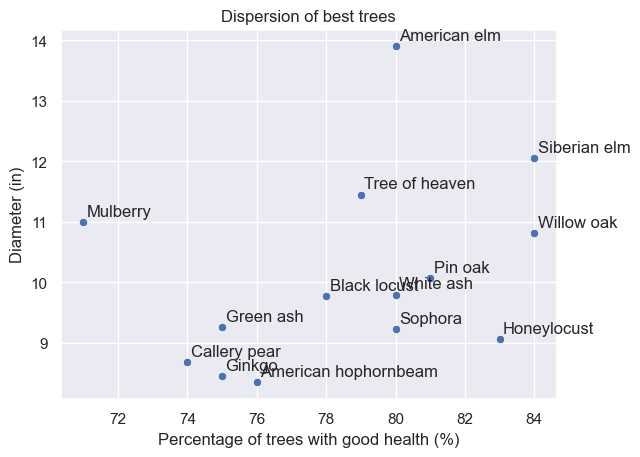

In [58]:
# now we see how health and diameter are related to
ax = sns.scatterplot(data=diam_heal, x="percentage", y="tree_dbh")
ax.set(title="Dispersion of best trees", xlabel="Percentage of trees with good health (%)", ylabel="Diameter (in)")

for i in diam_heal.values:
    plt.text(i[5]+0.1, i[6]+0.1, i[0])
    
plt.plot()

By the plot, we can see which are the best trees the city can plant in the future:

In [62]:
best_trees = diam_heal.sort_values(["percentage", "tree_dbh"], ascending=False)["spc_common"][:10].reset_index(drop=True)
best_trees

0            Siberian elm
1              Willow oak
2             Honeylocust
3                 Pin oak
4            American elm
5               White ash
6                 Sophora
7          Tree of heaven
8            Black locust
9    American hophornbeam
Name: spc_common, dtype: object